In [2]:
import torch

# 1. CUDA 사용 가능 여부 확인
print(f"CUDA Available: {torch.cuda.is_available()}")

# 2. 사용 가능한 GPU 개수
print(f"GPU Count: {torch.cuda.device_count()}")

# 3. 현재 GPU 이름 (RTX 4060이 나와야 함)
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# 4. 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CUDA Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 4060
Using device: cuda


In [3]:

# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image  
import numpy as np



In [ ]:
# 1. 데이터 로딩 및 전처리


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [6]:
# 2. CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device) # 모델을 GPU로 실행
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# 5. 학습 함수
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss 및 Accuracy 계산
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

# 6. 평가 함수
def evaluate(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total * 100
    return avg_loss, accuracy

In [8]:
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

best_test_acc = 0.0 # 가장 좋은 테스트 정확도를 기록하기 위한 변수 (이 부분을 학습 루프 외부에 정의)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, ')
    print(f' Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    # 가장 좋은 테스트 정확도를 기록할 때 모델을 저장()
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), f'best_model_epoch_{epoch+1}.pth') # 모델 저장
        print(f'Best model saved with Test Accuracy: {test_acc:.2f}% at Epoch {epoch+1}')

Epoch [1/10], Train Loss: 0.1489, Train Acc: 95.55%, 
 Test Loss: 0.0485, Test Acc: 98.41%
Best model saved with Test Accuracy: 98.41% at Epoch 1
Epoch [2/10], Train Loss: 0.0438, Train Acc: 98.60%, 
 Test Loss: 0.0313, Test Acc: 98.95%
Best model saved with Test Accuracy: 98.95% at Epoch 2
Epoch [3/10], Train Loss: 0.0324, Train Acc: 98.99%, 
 Test Loss: 0.0333, Test Acc: 98.90%
Epoch [4/10], Train Loss: 0.0234, Train Acc: 99.27%, 
 Test Loss: 0.0374, Test Acc: 98.87%
Epoch [5/10], Train Loss: 0.0181, Train Acc: 99.39%, 
 Test Loss: 0.0400, Test Acc: 98.82%
Epoch [6/10], Train Loss: 0.0147, Train Acc: 99.53%, 
 Test Loss: 0.0389, Test Acc: 98.84%
Epoch [7/10], Train Loss: 0.0105, Train Acc: 99.65%, 
 Test Loss: 0.0346, Test Acc: 99.06%
Best model saved with Test Accuracy: 99.06% at Epoch 7
Epoch [8/10], Train Loss: 0.0105, Train Acc: 99.64%, 
 Test Loss: 0.0356, Test Acc: 99.01%
Epoch [9/10], Train Loss: 0.0078, Train Acc: 99.76%, 
 Test Loss: 0.0357, Test Acc: 99.05%
Epoch [10/10], T

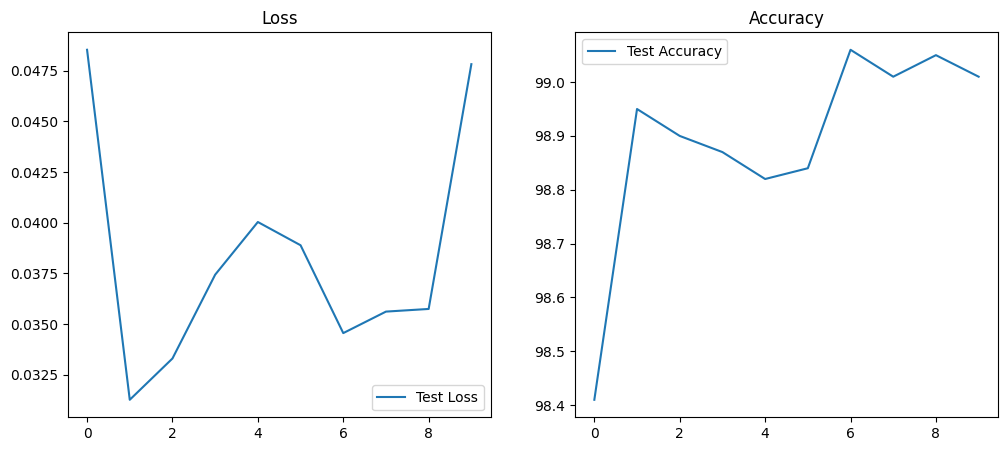

In [10]:
# 7. 성능 평가 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

모델이 예측한 숫자: 3


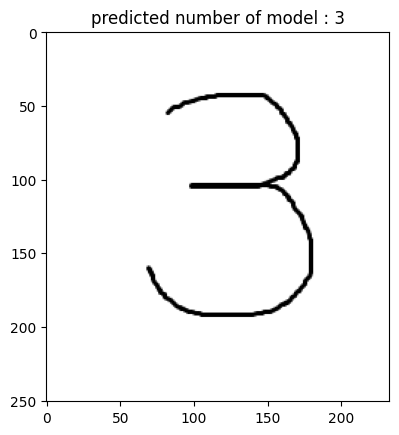

In [18]:
# 새로운 모델 인스턴스 생성 및 가중치 로드
from PIL import Image  # ✅ 대문자 I로 시작해야 합니다.


model = CNN().to(device)
model.load_state_dict(torch.load('best_model_epoch_7.pth', weights_only=True))
model.eval()

# 이미지 전처리 함수 정의
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L') # 그레이스케일
    image = np.array(image)
    image = Image.fromarray(255 - image) # 배경이 흰색이면 반전 필요
    
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return transform(image).unsqueeze(0)

# 예측 실행
image_path = 'sam.png' # 경로 수정 필요
image = preprocess_image(image_path).to(device)

with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    print(f"모델이 예측한 숫자: {predicted.item()}")

# 결과 시각화
plt.imshow(Image.open(image_path).convert('L'), cmap='gray')
plt.title(f"predicted number of model : {predicted.item()}")
plt.show()